<a href="https://colab.research.google.com/github/JulianSKYOO/colab/blob/main/Copy_of_Fintech_Society_X_DataSoc_Bitcoin_Prediction_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fintech Society X DataSoc: Bitcoin forecasting with RNN's



In [ ]:
!pip install yfinance
!pip install sktime


# To build our crypto prediction model we will use tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout

# We'll use sktime to help with splitting the data
from sktime.forecasting.model_selection import temporal_train_test_split

# The Yahoo finance API is imported to fetch the most recent data
import yfinance as yf

# Some other imports for EDA and pre-processing
from sklearn.preprocessing import StandardScaler
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np

%config InlineBackend.figure_format = 'svg'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


* We now source the data from yahoo finance using the `yf.download('BTC-AUD')` method.
* After doing this we can then observe the first few rows of the data using
`df.head()`. It is a useful check to see that all of our columns are being displayed correctly.
* `df` is being stored as a pandas dataframe so we can apply all the dataframe and series methods pandas has to offer

In [ ]:
df = yf.download('BTC-AUD')
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,513.122620,516.007935,504.935272,510.645386,510.645386,23511389
2014-09-18,510.116119,510.002228,459.924286,472.650330,472.650330,38400000
2014-09-19,472.275055,477.761017,428.161682,442.249359,442.249359,42477540
2014-09-20,442.111572,474.174957,436.745819,458.053101,458.053101,41294500
2014-09-21,457.135651,461.998413,440.440247,446.308197,446.308197,29744964


* We now visualise the data using the in-built `plot()` method from pandas
* In this case we are taking the bitcoin closing prices and showing a line plot
* By default it displays a line plot, which is ideal for observing a time-series
* Other things to tune include `color`, `figsize`, `ylabel` etc.

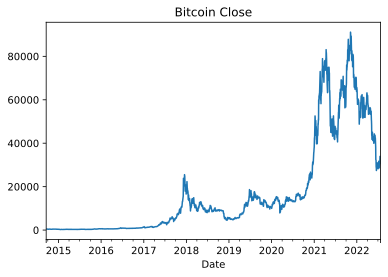

In [ ]:
df['Close'].plot(title='Bitcoin Close')

* For those more familiar with pandas, the dates are currently our index column
* This means that we can easily filter which time window we want to visualise with `df.loc[]`
* In this example, we just picked an arbitrary date of January 9 and visualised the trend of bitcoin beyond that point
* An an exercise, try observe that happened to bitcoin during just 2020 during the worst of COVID

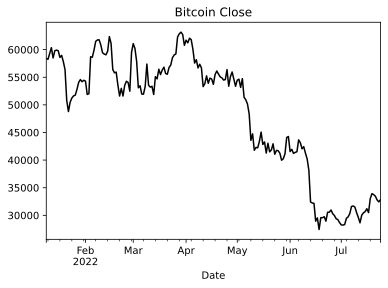

In [ ]:
# The colon at the very end ensures that we have no annoying text above the title when we plot
df.loc['January 9 2022':, 'Close'].plot(title='Bitcoin Close', color='black');

## Split data

* Ideally we would like some data to train the model that we build, and some data to evaluate how the model has done on unseen data.

* Though when making this important split of the data, we can't split the data randomly since we need to maintain continuity.

* This means that instead of drawing random samples from the data set to create the train and test set, we withhold a certain amount of data to act as the train set.

**See the diagram below for an example**

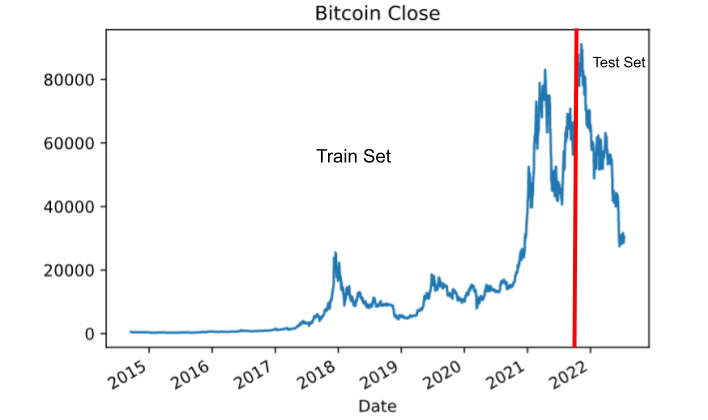

In [ ]:
# y is the thing we would like to try model. In our case it is bitcoin closing prices
y = df['Close']

# Split data into a train and test set
train, test = temporal_train_test_split(y, test_size=0.1)

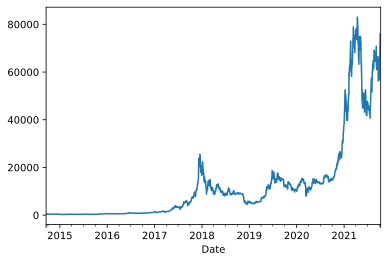

In [ ]:
# Plot the data used for training
train.plot()

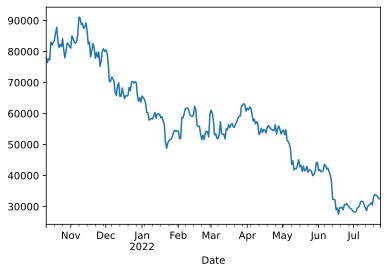

In [ ]:
# Plot the data used for testing
test.plot()

In [ ]:
# We will now store each series as a dataframe
# We do this so that scikit-learn can scale the values without us running into errors

train = pd.DataFrame(train)
test = pd.DataFrame(test)

## Scaling Data

* In machine learning tasks and in particular, deep learning, it is very common to **scale** the data, doine using the `StandardScaler()` class from `sklearn`
* This is because the majority of machine learning algorithms "learn" from data through what is known as **gradient descent**, which 'converges' faster when dealing with scaled values
* Find out more [here](https://machinelearningmastery.com/how-to-improve-neural-network-stability-and-modeling-performance-with-data-scaling/)!

---

For those familiar with statistics, the standard scaler transformation will shift the data so that it has mean 0 and variance 1. The new data is based off the calculation:

$$\frac{x - m}{s}$$

where $m$ is the **mean** of the training samples and $s$ is the sample **standard deviation**. Standard deviation is just a way to measure the <u>spread</u> that exists in the data.

---

You might notice that in the below code, we use a method called `fit_transform()` on the training data but only use `transform()` on the test data. In short, we do this to prevent what is known as **data leakage**, detailed [here](https://www.youtube.com/watch?v=6as06vtXNL8&t=3s)

In [ ]:
# Initialise scaler used to scale the data
scaler = StandardScaler()

# Perfrom the scaling
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

In [ ]:
# The data has been scaled, and observing its shape...
# ...we notice that it's shape is unchanged as expected

# It is just the values that change

print(train_scaled.shape)
print(test_scaled.shape)

(2581, 1)
(287, 1)


## Feature engineering (lags)

*A 'lag' is essentially a delay.*

For example, the 1 hour lag of 12pm is 11am.

In time series analysis, for lag 1, we compare the current time series with its past self exactly 1 time step in the past.

*See the diagram below for a more concrete example:*

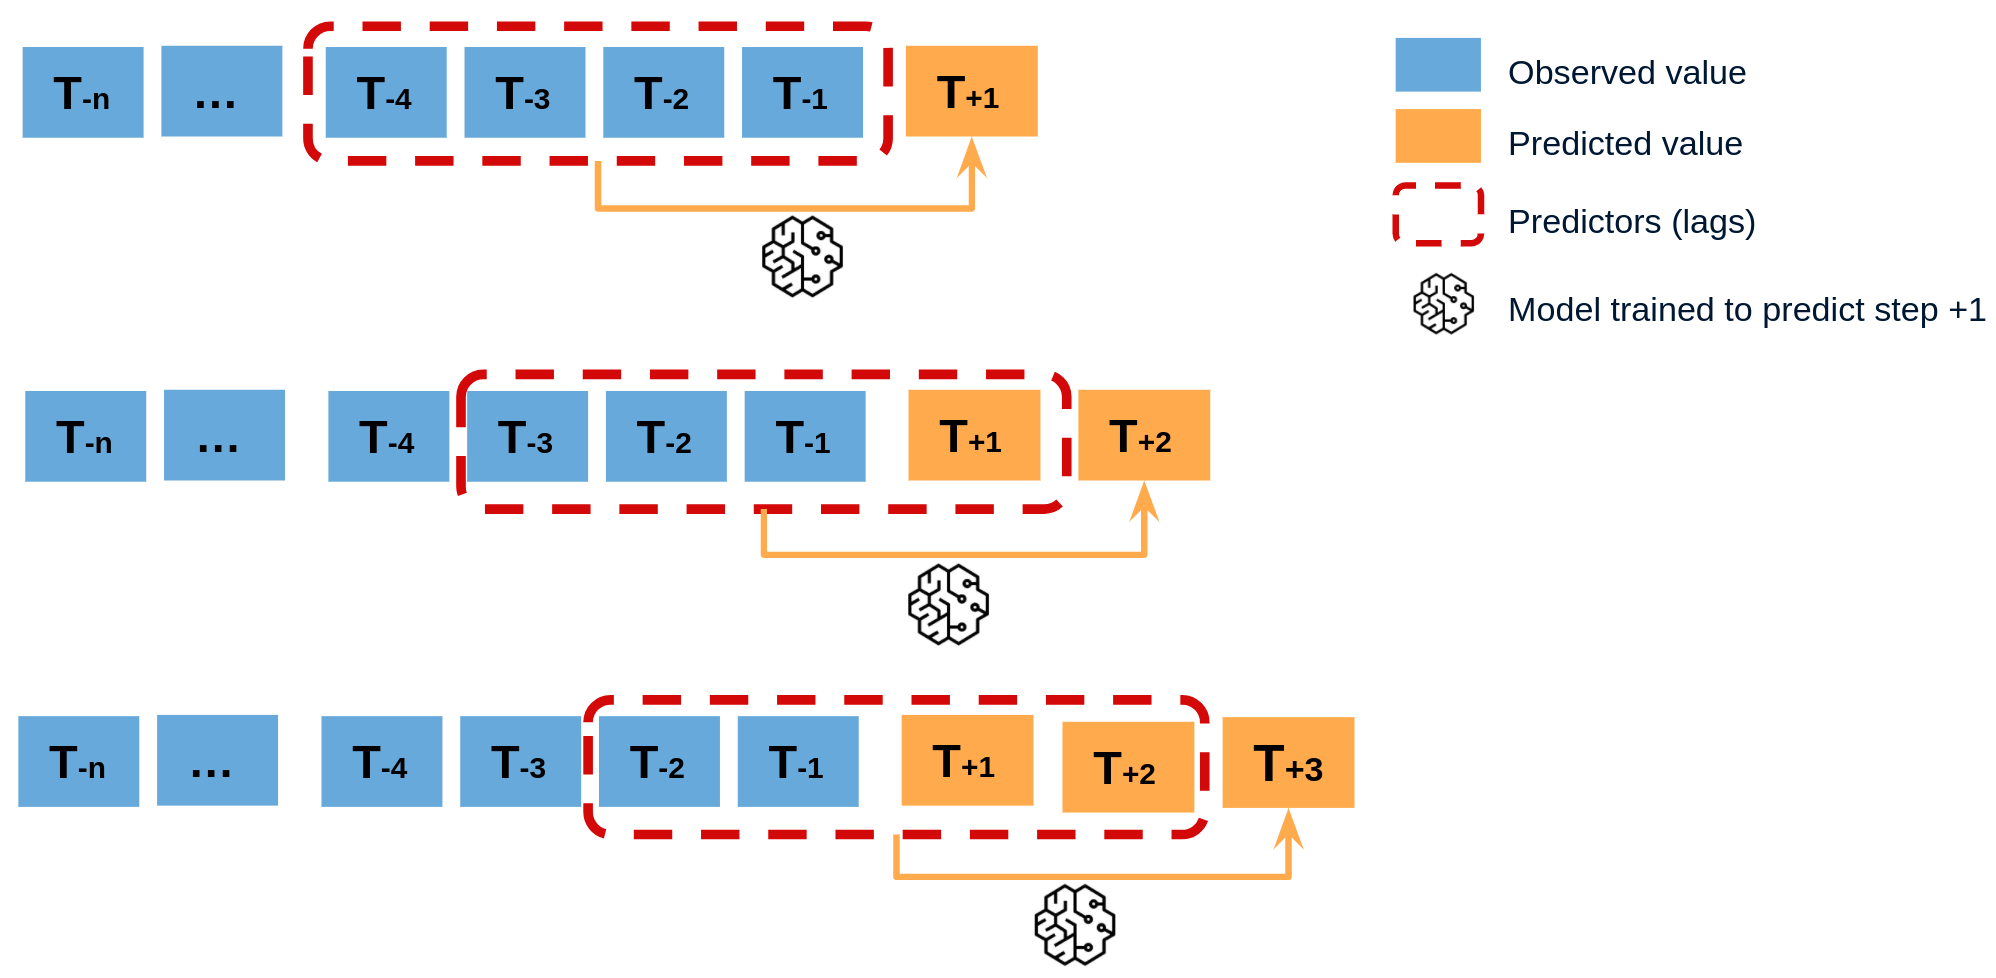
Source: https://www.cienciadedatos.net/documentos/py27-time-series-forecasting-python-scikitlearn.html

In [ ]:
def create_sequences(dataset, seq_size=1):
    """
    Creates a dataset suteable for tensorflow time series modelling
    -> time_step is the number of time steps to look back
    -> larger sequences might improve forecasts since it looks further back
    """
    X = []
    y = []
    for i in range(len(dataset)-seq_size-1):
        X.append(dataset[i:(i + seq_size), 0] )
        y.append(dataset[i + seq_size, 0])

    X = np.array(X)
    y = np.array(y)

    return X, y

In [ ]:
sequence_size = 5
X_train, y_train = create_sequences(dataset=train_scaled, seq_size=sequence_size)
X_test, y_test = create_sequences(dataset=test_scaled, seq_size=sequence_size)

Observe the first 15 rows to see what just happened

In [ ]:
train_scaled[:15]

array([[-0.67303308],
       [-0.67515083],
       [-0.6768453 ],
       [-0.67596444],
       [-0.67661907],
       [-0.67624174],
       [-0.67404276],
       [-0.6748657 ],
       [-0.67543576],
       [-0.67577152],
       [-0.6760835 ],
       [-0.67742197],
       [-0.67747084],
       [-0.67680734],
       [-0.67703653]])

In [ ]:
# we are fitting these values
X_train[:15]

array([[-0.67303308, -0.67515083, -0.6768453 , -0.67596444, -0.67661907],
       [-0.67515083, -0.6768453 , -0.67596444, -0.67661907, -0.67624174],
       [-0.6768453 , -0.67596444, -0.67661907, -0.67624174, -0.67404276],
       [-0.67596444, -0.67661907, -0.67624174, -0.67404276, -0.6748657 ],
       [-0.67661907, -0.67624174, -0.67404276, -0.6748657 , -0.67543576],
       [-0.67624174, -0.67404276, -0.6748657 , -0.67543576, -0.67577152],
       [-0.67404276, -0.6748657 , -0.67543576, -0.67577152, -0.6760835 ],
       [-0.6748657 , -0.67543576, -0.67577152, -0.6760835 , -0.67742197],
       [-0.67543576, -0.67577152, -0.6760835 , -0.67742197, -0.67747084],
       [-0.67577152, -0.6760835 , -0.67742197, -0.67747084, -0.67680734],
       [-0.6760835 , -0.67742197, -0.67747084, -0.67680734, -0.67703653],
       [-0.67742197, -0.67747084, -0.67680734, -0.67703653, -0.67771722],
       [-0.67747084, -0.67680734, -0.67703653, -0.67771722, -0.67839094],
       [-0.67680734, -0.67703653, -0.6

In [ ]:
# ...to this output
y_train[:15]

array([-0.67624174, -0.67404276, -0.6748657 , -0.67543576, -0.67577152,
       -0.6760835 , -0.67742197, -0.67747084, -0.67680734, -0.67703653,
       -0.67771722, -0.67839094, -0.68036041, -0.68086887, -0.6805099 ])

In [ ]:
# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] , 1)

In [ ]:
print(X_train.shape)

(2575, 5, 1)


## Building the model

To build the model we're going to use the popular deep learning package, *Tensorflow*.

Tensorflow lets us specify from a high level the architecture of our network.

In [ ]:
import tensorflow as tf

tf.random.set_seed(1)

model = Sequential()

# Add LSTM Layer with 16 LSTM units
model.add(LSTM(units=16, input_shape=(None, 1), activation='tanh', recurrent_activation='sigmoid'))

# Final layer with 1 neuron
model.add(Dense(units=1))

# Define L as mean squared error and minimise using the ADAM optimiser
model.compile(loss='mse', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 16)                1152      
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 1,169
Trainable params: 1,169
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# batch_size      -> Number of training samples used to compute gradient required for gradient descent

# verbose         -> How much detail to specify in the output

# epochs          -> Number of iterations in training the model

# validation_data -> Data on which to evaluate the loss and any model metrics at the end of each epoch.
#                    The model will not be trained on this data though!

model.fit(X_train,
          y_train,
          batch_size=32,
          verbose=1,
          epochs=30,
          validation_data=(X_test, y_test))

Epoch 1/30
81/81 [==============================] - 4s 13ms/step - loss: 0.6036 - val_loss: 0.9040
Epoch 2/30
81/81 [==============================] - 0s 6ms/step - loss: 0.0461 - val_loss: 0.2503
Epoch 3/30
81/81 [==============================] - 1s 9ms/step - loss: 0.0244 - val_loss: 0.2162
Epoch 4/30
81/81 [==============================] - 1s 10ms/step - loss: 0.0195 - val_loss: 0.1754
Epoch 5/30
81/81 [==============================] - 1s 9ms/step - loss: 0.0157 - val_loss: 0.1482
Epoch 6/30
81/81 [==============================] - 1s 10ms/step - loss: 0.0128 - val_loss: 0.1157
Epoch 7/30
81/81 [==============================] - 1s 9ms/step - loss: 0.0107 - val_loss: 0.0940
Epoch 8/30
81/81 [==============================] - 1s 9ms/step - loss: 0.0089 - val_loss: 0.0811
Epoch 9/30
81/81 [==============================] - 1s 10ms/step - loss: 0.0078 - val_loss: 0.0649
Epoch 10/30
81/81 [==============================] - 1s 11ms/step - loss: 0.0071 - val_loss: 0.0558
Epoch 11/30
81

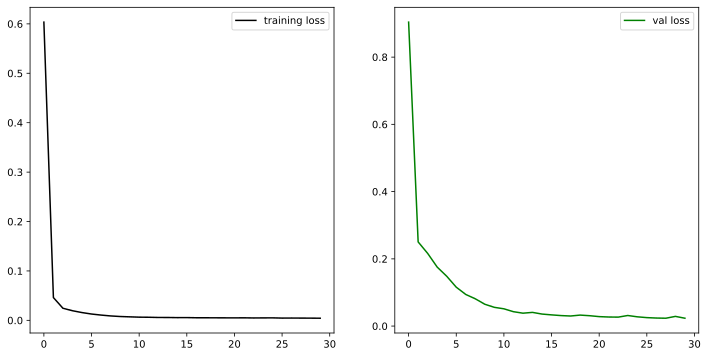

In [ ]:
fig, (ax1, ax2) = plt.subplots(figsize=(12, 6), ncols=2)

sns.lineplot(x=model.history.epoch,
             y=model.history.history['loss'],
             color='black',
             label='training loss',
             ax=ax1)

sns.lineplot(x=model.history.epoch,
             y=model.history.history['val_loss'],
             color='green',
             label='val loss',
             ax=ax2)

## Let's make some predictions

In [ ]:
# Get predictions back into unscaled values
yhat_train = scaler.inverse_transform(model.predict(X_train))
yhat_test = scaler.inverse_transform(model.predict(X_test))

In [ ]:
y_train = scaler.inverse_transform([y_train])
y_test = scaler.inverse_transform([y_test])

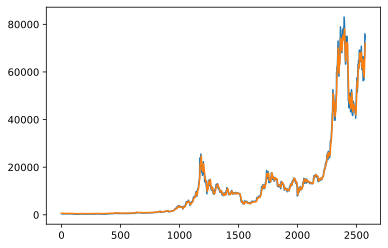

In [ ]:
plt.plot(y_train[0, :])
plt.plot(yhat_train)

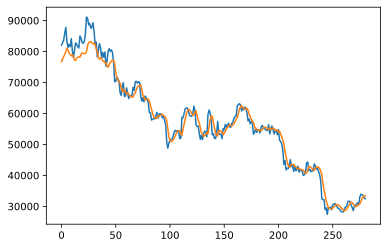

In [ ]:
# Look at these amazing results!!
# Unfortunately they are not actually so amazing because there are caveats in our model
# See a few cells below for more details
plt.plot(y_test[0, :])
plt.plot(yhat_test)

In [ ]:
np.array(df.Close).reshape([-1,1])

array([[  510.64538574],
       [  472.65032959],
       [  442.24935913],
       ...,
       [32791.34375   ],
       [32436.44335938],
       [32816.88671875]])

## Caveats

### Assuming stationary data

A key assumption we make when standardising the data is that the mean and variance does not change over time. This assumption is not justified (unless we use an Augmented Dickey-Fuller test), meaning we've introduced incorrect assumptions into our model.


### Data leakage

Consider what happens when we predict data.

To predict Bitcoin's price 7 days head, we've taken all data up to and not including the 7th day. In this way we've cheated!! Realistically, this is not possible either since we can't use future data to predict a future value, we can only use historical data.

---

In summary, while this model is able to generate predictions, it is not ideal since we:

* [Used prices as inputs](https://www.youtube.com/watch?v=aIklUbW0UWI) -> but our data is not stationary
* [Used prices as targets](https://www.youtube.com/watch?v=xOcyV5Q2G5I&t=23s) -> a better option might be to try model [log returns](https://investmentcache.com/magic-of-log-returns-concept-part-1/) since they are **almost** stationary
* Split the training and test test in a way such that each value was predicted from it's true past. See [this video](https://www.youtube.com/watch?v=6t9hKclQNH4&t=296s) to further see why this is problematic
